<a href="https://colab.research.google.com/github/katearb/ipynb-projects/blob/master/w7_AdvancedRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [ ]:
!pip install bds_courseware
from bds_courseware import read_drive_dataset
from bds_courseware import print_dataset_description, print_module_datasets
from bds_courseware import HOMEWORK_DATASETS
name = 'bike_sharing_hour'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
import calendar
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_absolute_error as mae
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA

In [ ]:
import random
random.seed(12)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = read_drive_dataset(*HOMEWORK_DATASETS[name])
df.set_index('instant', inplace=True)

# EDA

In [ ]:
# general info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  casual      17379 non-null  int64  
 14  registered  17379 non-null  int64  
 15  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 2.3+ MB


Most of the features seem to be numeric. However, from the data description, we find out that many features are categorical ones.

## Univariate analysis

In [ ]:
def draw_distr(feature, title='', bins='auto'):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

  sns.distplot(x=feature, bins=bins, ax=ax1)
  ax1.set_title(f'Distribution of {title}')

  sns.boxplot(x=feature, ax=ax2)
  ax2.set_title(f'Boxplot of {title}')

  plt.show()

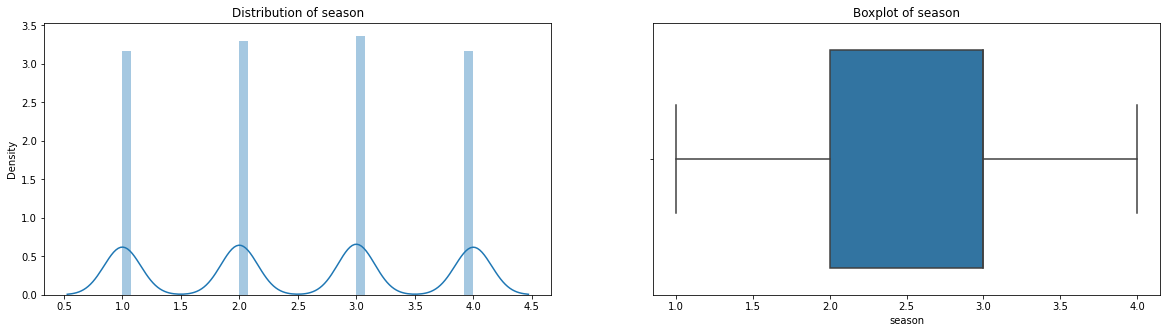

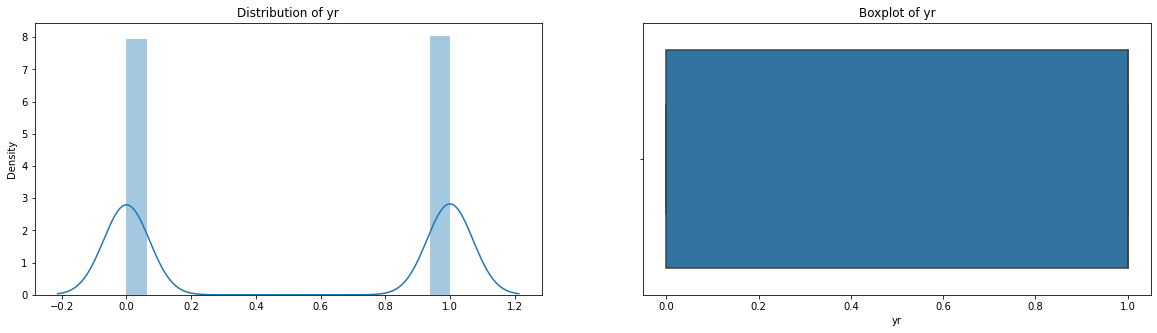

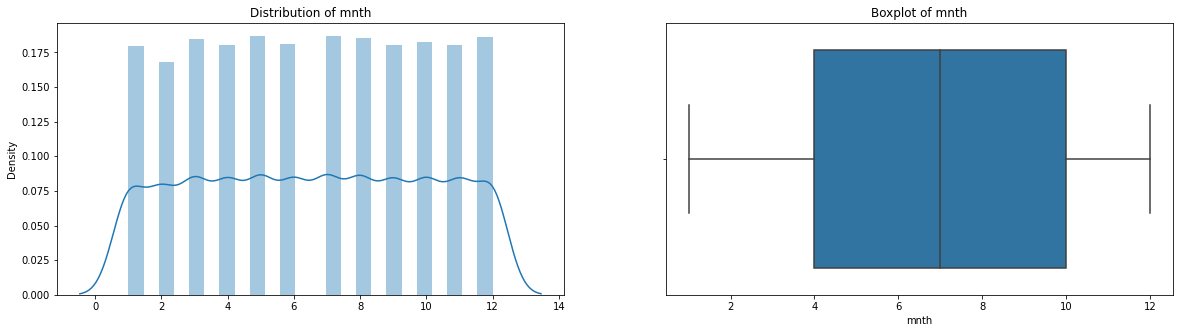

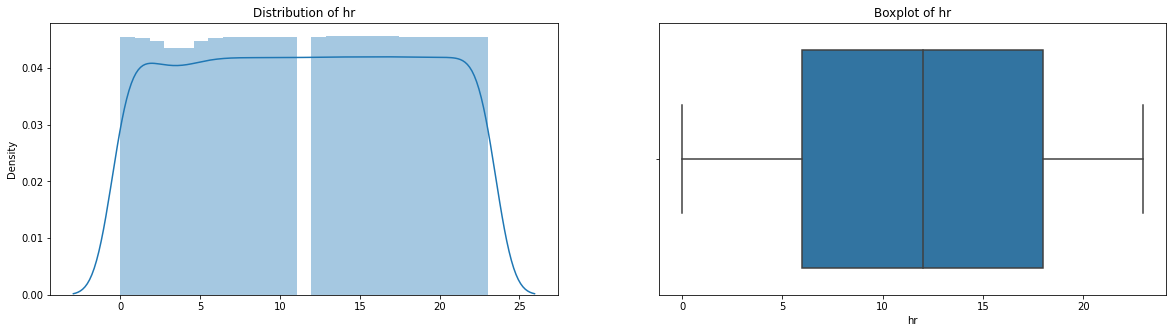

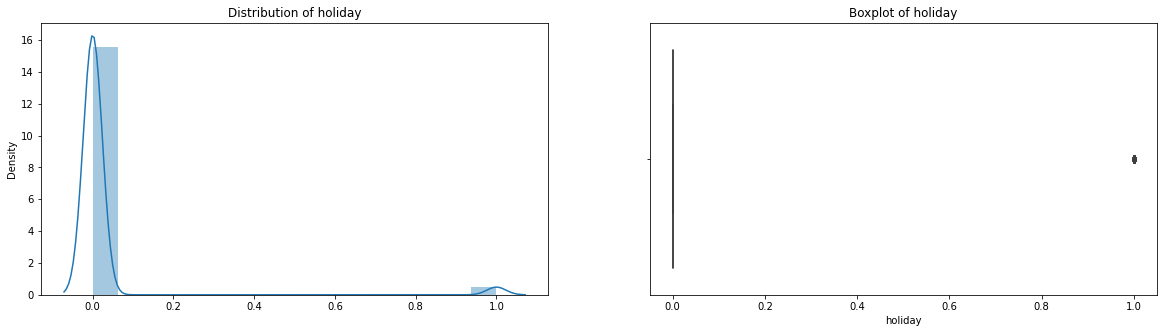

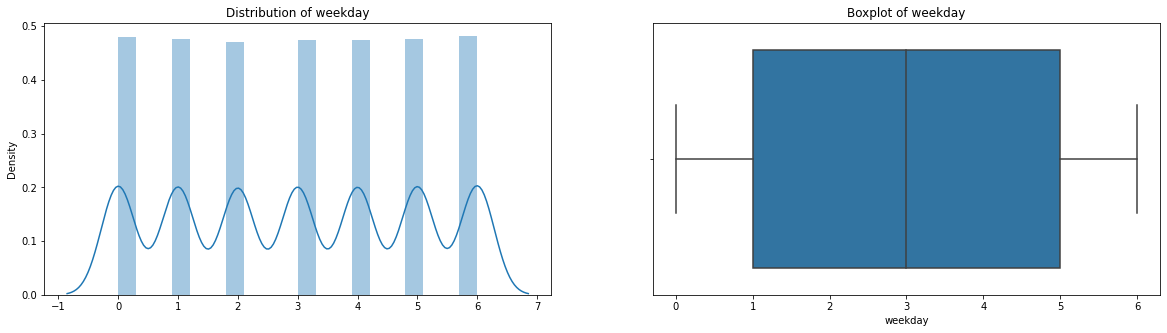

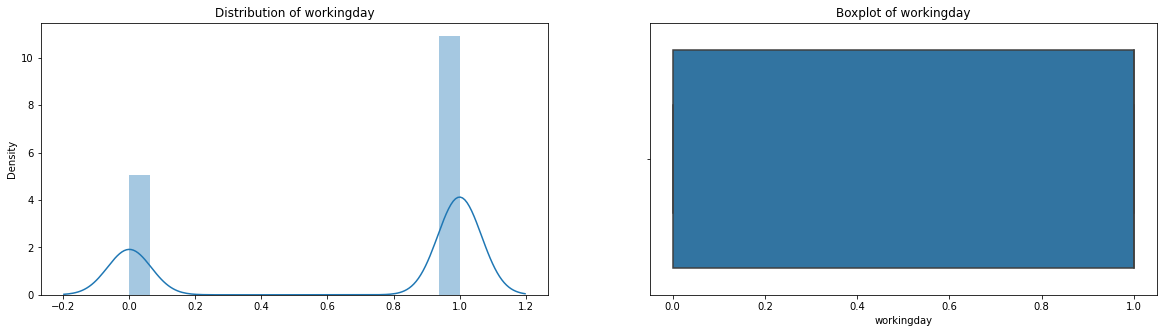

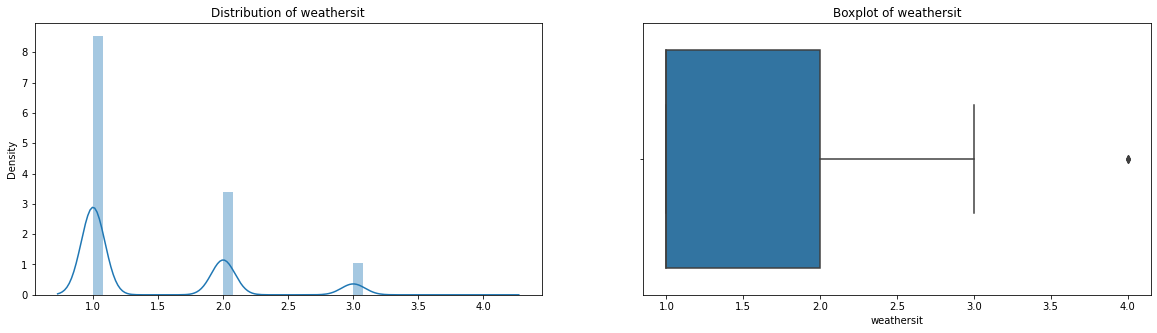

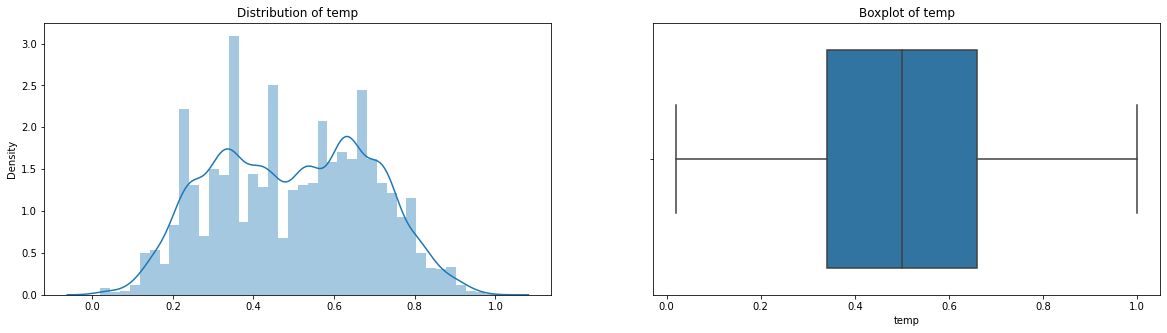

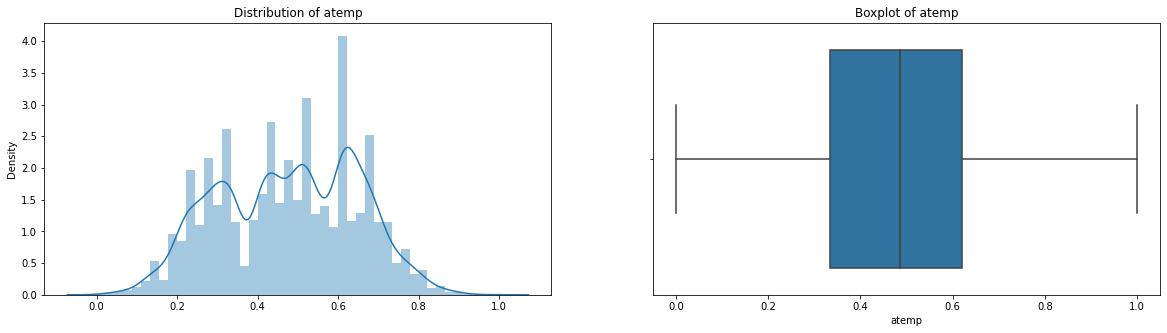

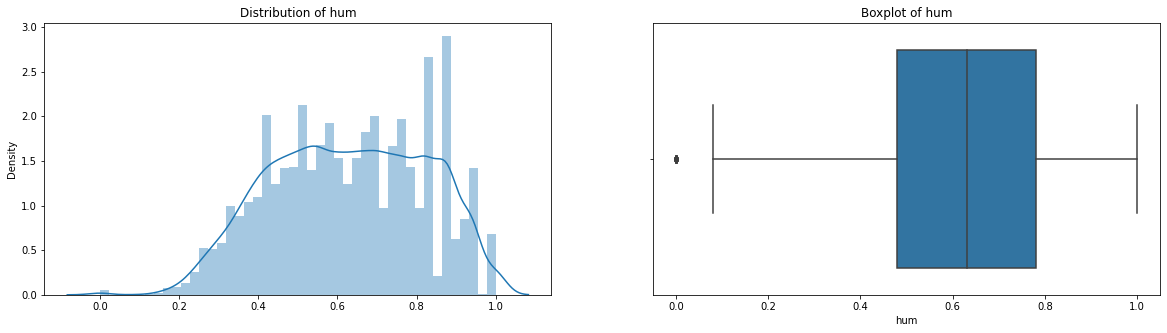

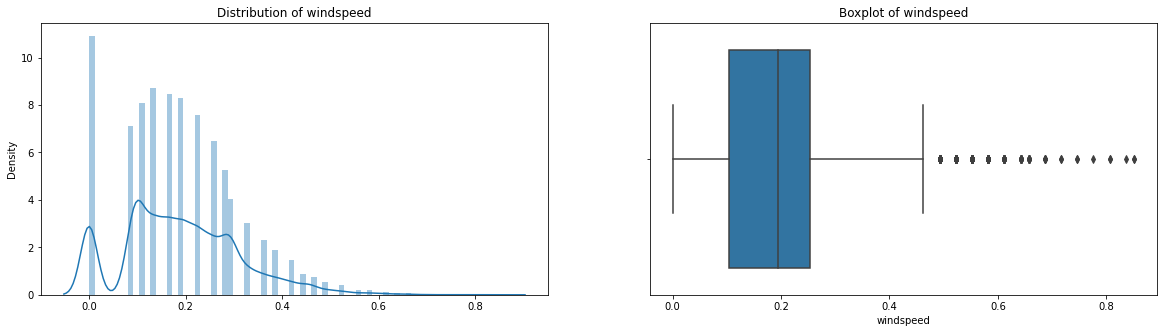

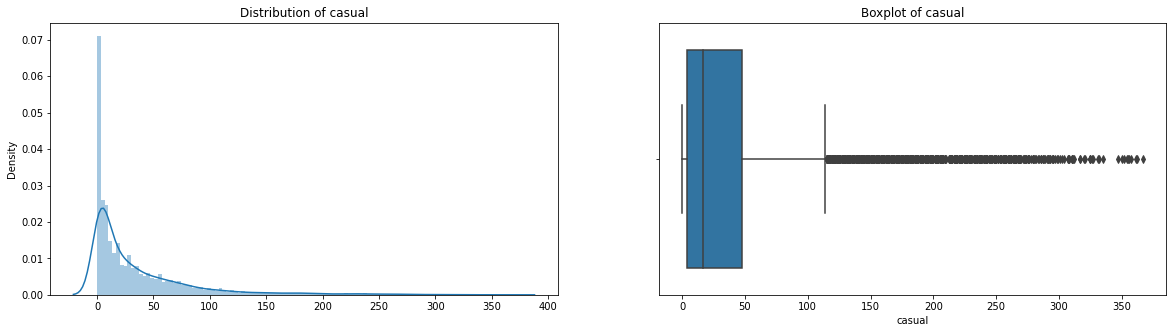

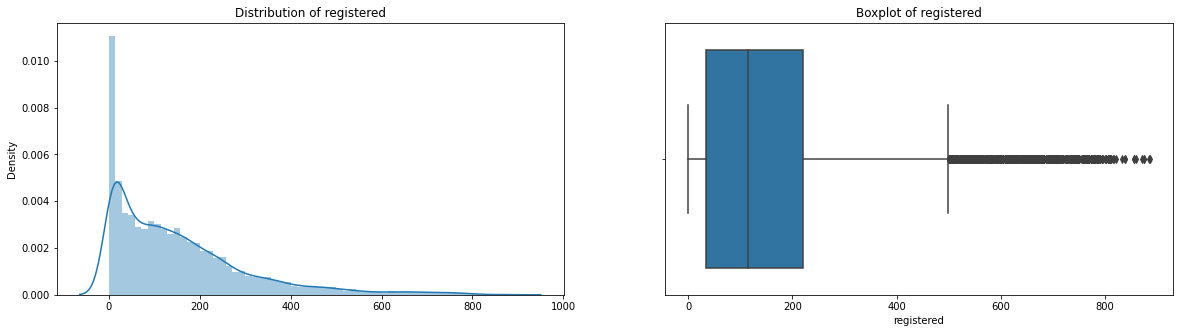

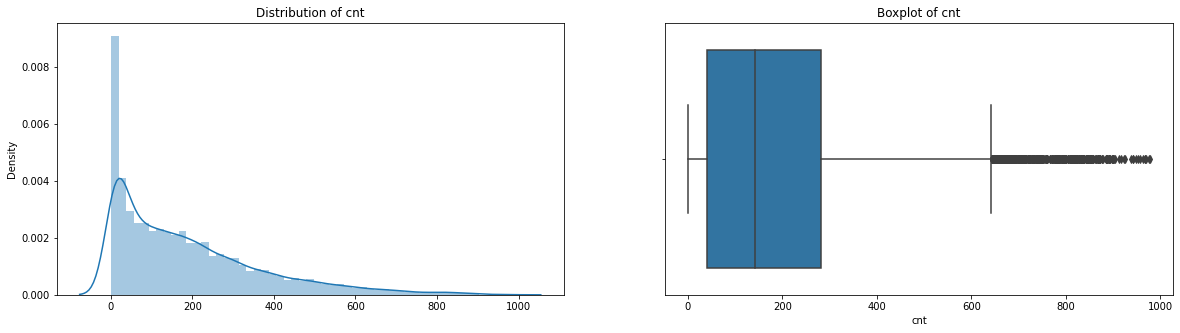

In [ ]:
for col in df.columns[1:]:
  draw_distr(df[col], col)

### Observations:
1. Most of the feature are whether categorical or binary. --> encoding is needed
2. Those features which are numeric by their nature (temperature, feeling temperature, humidity, windspeed) are already normalized.
3. Temp has a symmetric distribution, but unlike to normal distribution it has two modes --> maping to normal distribution is needed.
4. Atemp is also symmetric and has several modes. --> maping to normal distribution is needed.
5. Hum has negative kurtosis and is a bit skewed to the left.
6. The wind speed has a lot of 0 values. The other values are distributed with positive skewness.
7. The target is numeric and not normalized. Its distribution is skewed positively.

### Univariate analysis of categorical features

In [ ]:
cat = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
num = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']
target = 'cnt'

In [ ]:
def draw_pie(feature, title=''):
  pie_info = feature.value_counts()
  plt.figure(figsize=(5, 5))
  plt.pie(pie_info, labels=pie_info.index)
  plt.title(title)
  plt.show()

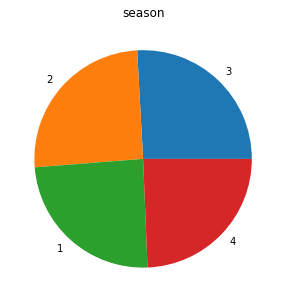

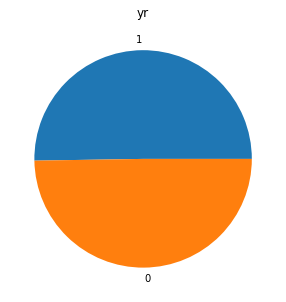

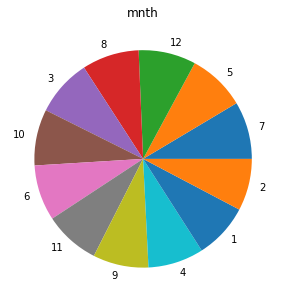

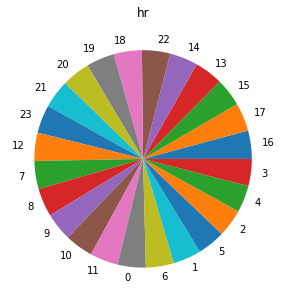

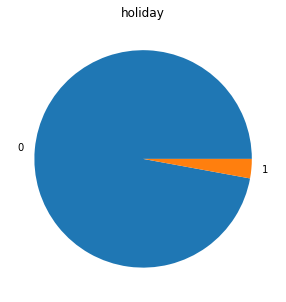

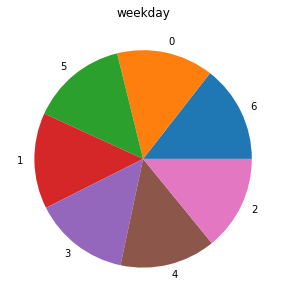

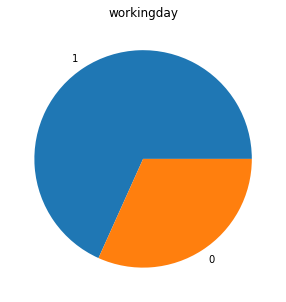

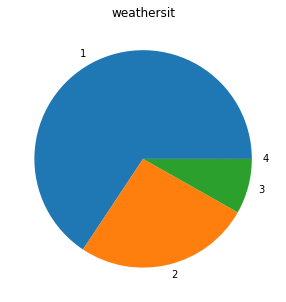

In [ ]:
for col in cat:
  draw_pie(df[col], col)

For sure, features which represent calendar units (like year, month, weekday) are equally distributed over their values. Holiday feature has low variance.

Talking about the weather, I can say that it is mostly sunny in Washington and heavy rain hardly ever can be seen there. What good conditions for bicycles!

## Multivariate analysis

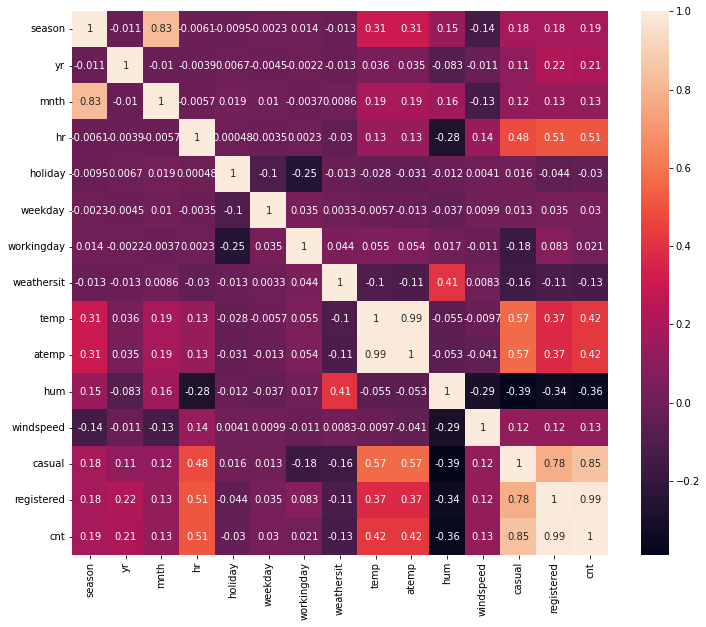

In [ ]:
# correlation
df_corr = df.corr('spearman')
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=True)
plt.show()

* While learning, "hr" feature will be the most influential as it has the highest correlation coef with the target.
* Humidity negatively affects rental count rates.
* Current hour is more important than current season because the difference in rental rates is much bigger between "day and night" compared to "summer and winter".
* Temperature and feeling temperature are equally important because their correlation coefficient is almost 1.

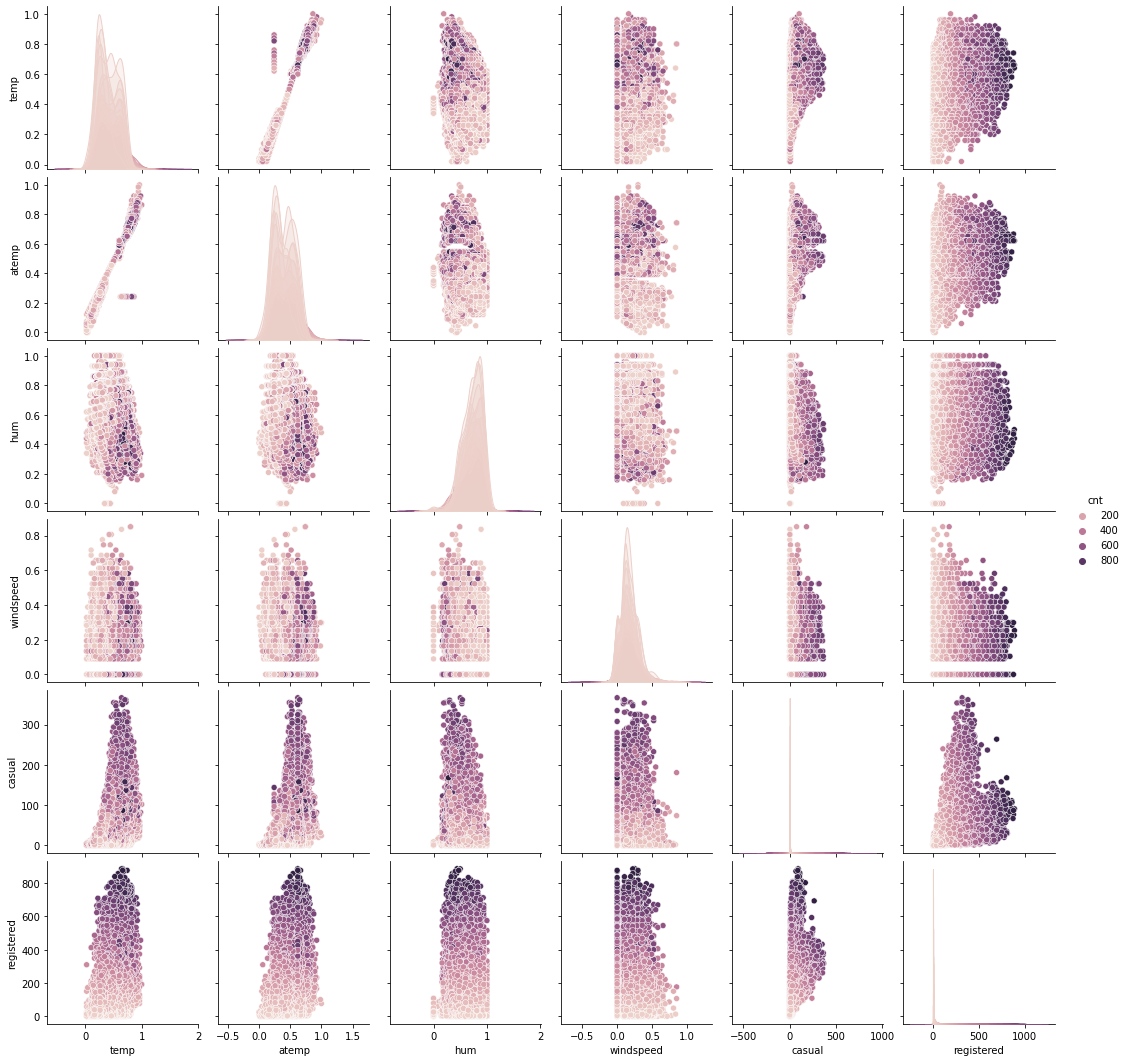

In [ ]:
sns.pairplot(df[num +[target]], hue=target)
plt.show()

Multicorrelation between some features is observed:
  * Between time-related features: month-season
  * between seasom and temperatures
  * between weather rate and humidity, as weathersit reflects rain aswell
  * between target related features.

Target is mostly correlated with hour, temperatures, humidity (negatively), year and season.

In [ ]:
df['dteday'] = df['dteday'].astype(np.datetime64)

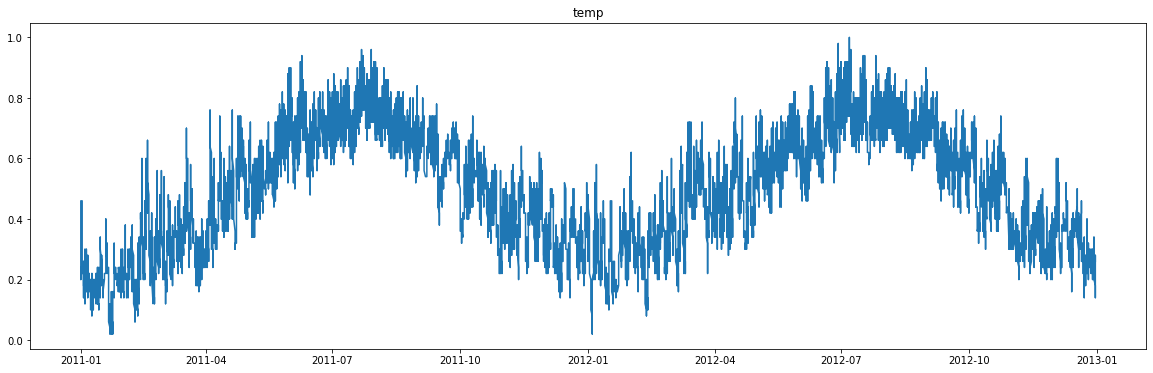

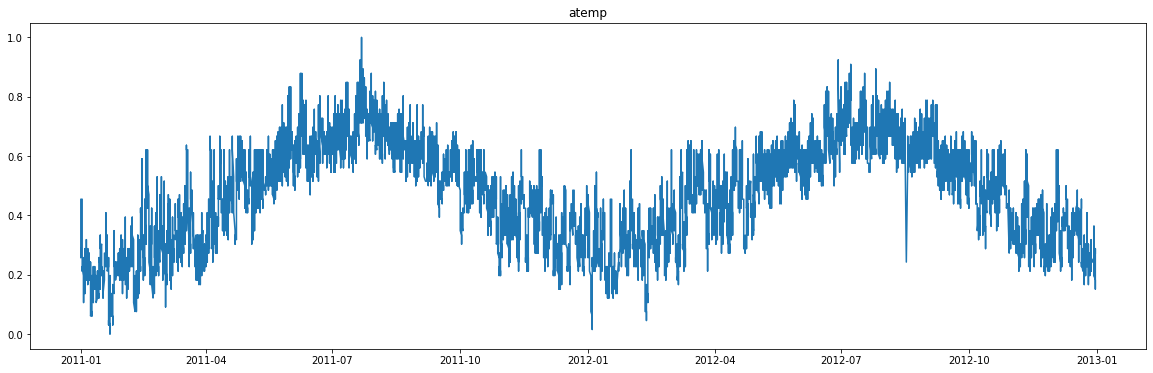

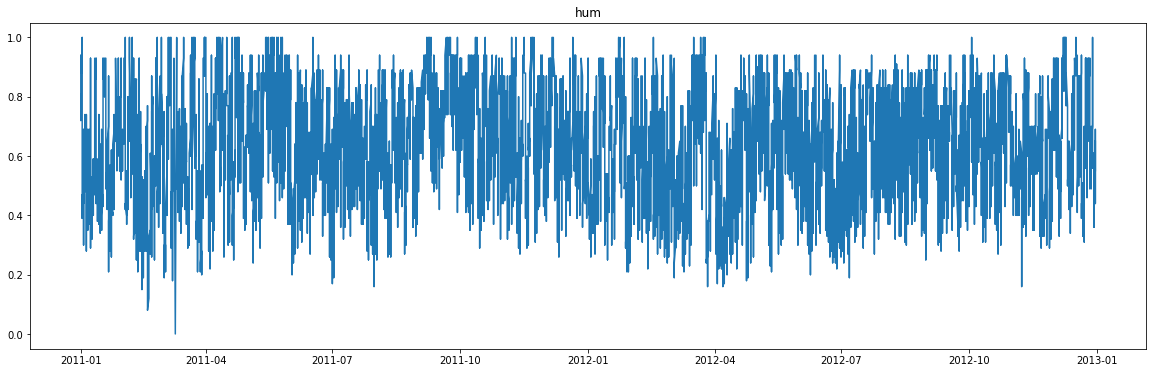

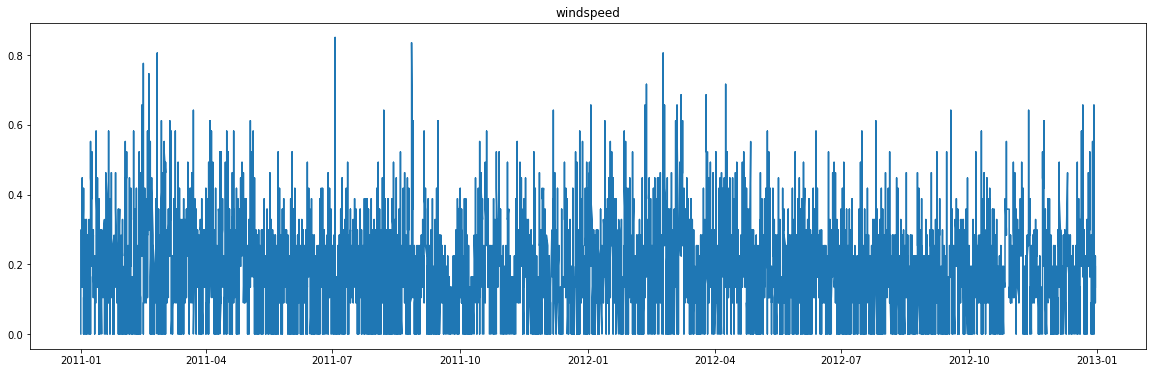

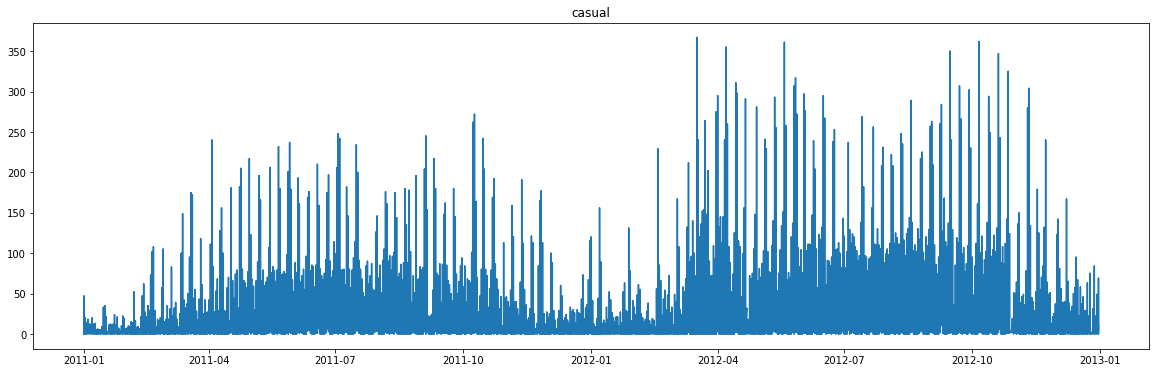

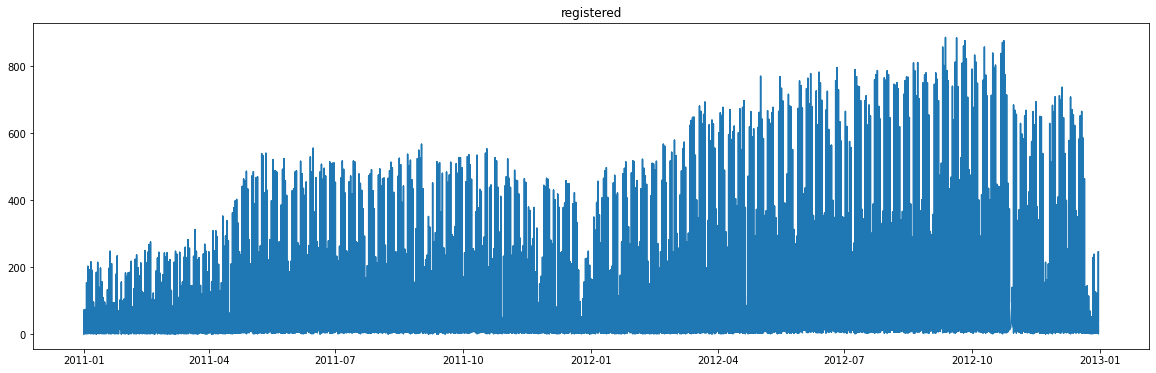

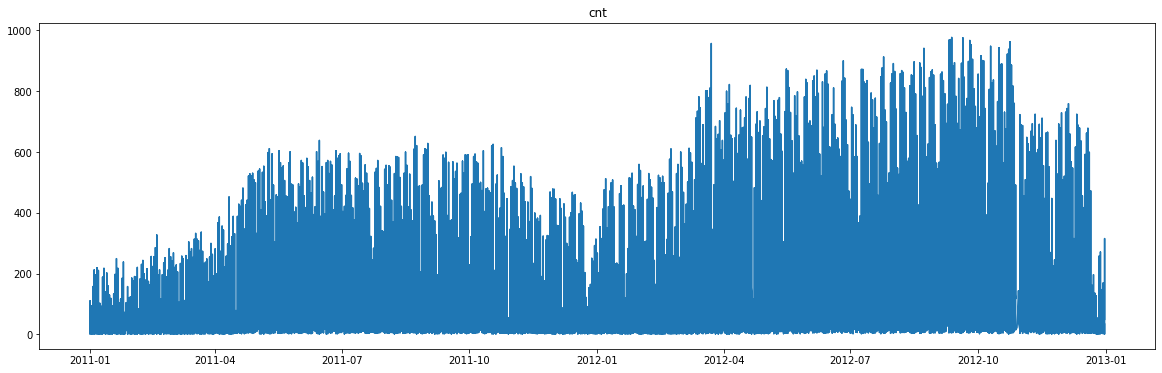

In [ ]:
for feature in num + [target]:
  plt.figure(figsize=(20, 6))
  plt.plot(df['dteday'], df[feature])
  plt.title(feature)
  plt.show()

Some periodic pattern is observed on some plot with repid = year. 

However, I **intentionally** will not use time feature per se and Time Series related techniques in this notebook as the following module's homework aims at this.

# Data Preparation

In [ ]:
casual = df['casual']
registered = df['registered']
df.drop(['casual', 'registered'], axis=1, inplace=True)
num.remove('casual')
num.remove('registered')

In [ ]:
# considering also to remove season as it is highly correlated with many features
season = df['season']
df.drop('season', axis=1, inplace=True)
cat.remove('season')

In [ ]:
# as dteday info is already reflected in the feaures yr and mnth, it can be deleted
dtime = df['dteday']
df.drop('dteday', axis=1, inplace=True)

In [ ]:
df['yr'] = df['yr'].map({0: '2011', 1: '2012'})
df['mnth'] = df['mnth'].apply(lambda x: calendar.month_name[x])
df['holiday'] = df['holiday'].map({1: 'True', 0: 'False'})
df['weekday'] = df['weekday'].apply(lambda x: calendar.day_name[x])
df['workingday'] = df['workingday'].map({0: 'False', 1: 'True'})

In [ ]:
#ecoding
ohe = OneHotEncoder(sparse=False, drop='first')
df_cat = pd.DataFrame(ohe.fit_transform(df[cat]), index=df.index)
df_cat.columns = ohe.get_feature_names(cat)

In [ ]:
y = df[target]
X = pd.concat([df[num], df_cat], axis=1)

In [ ]:
X

,temp,atemp,hum,windspeed,yr_2012,mnth_August,mnth_December,mnth_February,mnth_January,mnth_July,mnth_June,mnth_March,mnth_May,mnth_November,mnth_October,mnth_September,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,holiday_True,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,workingday_True,weathersit_2,weathersit_3,weathersit_4
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.24,0.2879,0.81,0.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.22,0.2727,0.80,0.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.22,0.2727,0.80,0.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.24,0.2879,0.75,0.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.24,0.2879,0.75,0.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,0.26,0.2576,0.60,0.1642,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
17376,0.26,0.2576,0.60,0.1642,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
17377,0.26,0.2576,0.60,0.1642,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
# mapping features to normal distribution
log_transformer = FunctionTransformer(np.log1p)
X_train = log_transformer.fit_transform(X_train)
X_test = log_transformer.fit_transform(X_test)

# Fit-Predict

Models' comparison is provided in the next section.

In [ ]:
scores = {}

In [ ]:
def tune_parameters(X, y, model, params, cv):
  scorer = make_scorer(mae)
  CV_rfc = RandomizedSearchCV(model, params, cv=cv, scoring=scorer)
  CV_rfc.fit(X, y)
  return CV_rfc.best_params_

def fit_model(model, X_train, y_train, X_test, y_test, model_params, model_name, tune=True, **kwargs):
  if tune:
    tt_model = TransformedTargetRegressor(regressor=model(**kwargs),
                                    func=np.log, inverse_func=np.exp)
    best_params = tune_parameters(X_train, y_train, tt_model, model_params, 3)
    print('Best parameters:', best_params)
    tt_model = TransformedTargetRegressor(regressor=model(**kwargs),
                                        func=np.log, inverse_func=np.exp)
    tt_model.set_params(**best_params)
  else:
    tt_model = TransformedTargetRegressor(regressor=model(**kwargs),
                                        func=np.log, inverse_func=np.exp)
  start = time.time()
  tt_model.fit(X_train, y_train)
  fin = time.time()
  scores[model_name] = [mae(y_test, tt_model.predict(X_test)), fin - start]
  return tt_model


def draw_feature_importance(coef):
  plt.figure(figsize=(8, 7))
  coef.nlargest(15).plot(kind='barh')
  plt.title('Feature Importance')
  plt.show()

### Linear + Ridge + Lasso

In [ ]:
lr_params = {'regressor__fit_intercept': [True, False]}

# lr = fit_model(LinearRegression, X_train, y_train, X_test, y_test, lr_params, 'linear')
lr = fit_model(LinearRegression, X_train, y_train, X_test, y_test, lr_params, 'linear', False, **{'fit_intercept': True}) # precomputed

In [ ]:
lasso_params = {'regressor__fit_intercept': [True, False],
             'regressor__alpha': np.arange(0.1, 2.0, 0.2)}
             
# lasso = fit_model(Lasso, X_train, y_train, X_test, y_test, lasso_params, 'Lasso')
lasso = fit_model(Lasso, X_train, y_train, X_test, y_test, lasso_params, 'Lasso', False, **{'fit_intercept': True, 'alpha': 1.9})

In [ ]:
ridge_params = {'regressor__fit_intercept': [True, False],
             'regressor__alpha': np.arange(0.1, 2.0, 0.2)}
             
# ridge = fit_model(Ridge, X_train, y_train, X_test, y_test, ridge_params, 'Ridge')
ridge = fit_model(Ridge, X_train, y_train, X_test, y_test, ridge_params, 'Ridge', False, **{'fit_intercept': False, 'alpha': 1.9})

KNN

In [ ]:
knn_params = {
    'regressor__n_neighbors': range(2, 15, 2),
    'regressor__weights': ['uniform', 'distance'],
    'regressor__leaf_size': [5, 10, 15, 30]
}
# knn = fit_model(KNeighborsRegressor, X_train, y_train, X_test, y_test, knn_params, 'KNN')

tuned_knn_params = {'weights': 'uniform', 'n_neighbors': 8, 'leaf_size': 30}
knn = fit_model(KNeighborsRegressor, X_train, y_train, X_test, y_test, knn_params, 'KNN', False, 
                **tuned_knn_params)  # precomputed

Decision Tree Regressor

In [ ]:
tree_params = {
    'regressor__max_depth': range(5, 15, 3),
    'regressor__min_samples_leaf': range(1, 10, 2)
}
# tree = fit_model(DecisionTreeRegressor, X_train, y_train, X_test, y_test, tree_params, 'Tree',
#          **{'criterion': 'mae'})

tuned_tree_params = {'criterion': 'mae', 'min_samples_leaf': 9, 'max_depth': 5}
tree = fit_model(DecisionTreeRegressor, X_train, y_train, X_test, y_test, tree_params, 'Tree', False,
          **tuned_tree_params)  # precomputed

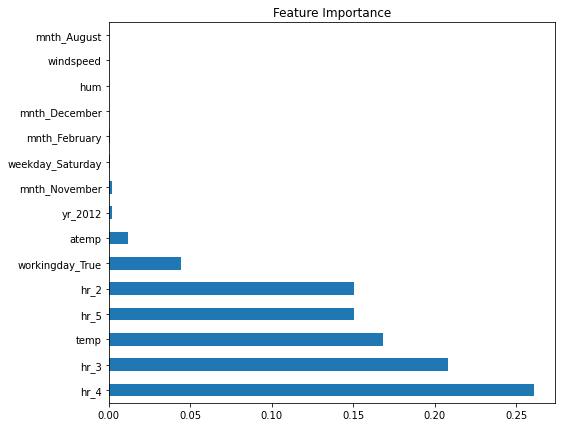

In [ ]:
draw_feature_importance(pd.Series(tree.regressor_.feature_importances_, index=X.columns))

Hour related features are the most important ones. It is not a surprise as number of rented bykes depends on people's day rhythm.
Temperature also plays a significant role.
The importance of the feature working_day_True says that people mostly rent bikes to go to work or to go home after.

Random Forest

In [ ]:
rf_params = {
    'regressor__n_estimators': range(100, 300, 100),
    'regressor__max_depth': [10, 20, 30],
    'regressor__min_samples_leaf': [3, 5, 8]
}
# rf = fit_model(RandomForestRegressor, X_train, y_train, X_test, y_test, rf_params, 'Random_Forest')
tuned_rf_params = {'n_estimators': 100, 'min_samples_leaf': 3, 'max_depth': 10}
rf =  fit_model(RandomForestRegressor, X_train, y_train, X_test, y_test, rf_params, 'Random_Forest', False,
                **tuned_rf_params)

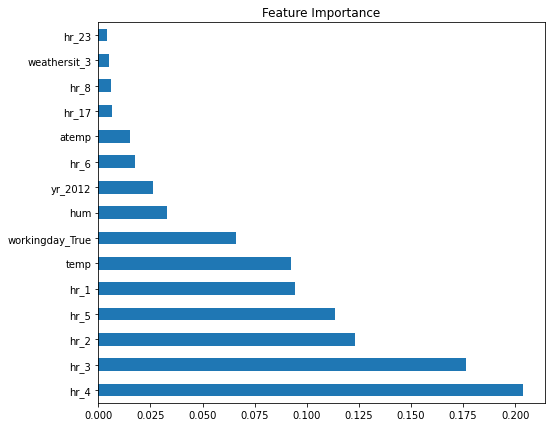

In [ ]:
draw_feature_importance(pd.Series(rf.regressor_.feature_importances_, index=X.columns))

Feature importances are similar to the previous one.

SVR

In [ ]:
svr_params = {
    'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'regressor__degree': [2, 3],
    'regressor__C': np.arange(0.1, 1.0, 0.3)
}
# svr = fit_model(SVR, X_train, y_train, X_test, y_test, svr_params, 'SVR')
tuned_svr_params = {'kernel': 'sigmoid', 'degree': 2, 'C': 0.1}  # precomputed
svr = fit_model(SVR, X_train, y_train, X_test, y_test, svr_params, 'SVR', False,
                **tuned_svr_params)

Catboost

In [ ]:
from catboost import CatBoostRegressor

X_train_cat, X_test_cat, y_train, y_test = train_test_split(df.drop(target, axis=1), y, test_size=0.1)
cat_params = {
    'iterations': range(100, 300, 80),
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': range(10, 16, 3),
    'l2_leaf_reg': [0.1, 0.5, 1]
}
#rs_ct = cat_b.randomized_search(cat_params,
#                                X_train_cat,
#                                y=y_train,
#                                train_size=0.9,
#                                plot=True)

best_cat_params = {'cat_features': [0, 1, 2, 3, 4, 5, 6],
 'depth': 10,
 'iterations': 260,
 'l2_leaf_reg': 0.5,
 'learning_rate': 0.2,
 'loss_function': 'MAE'}  # precomputed

cat_b = CatBoostRegressor(**best_cat_params)
start = time.time()
cat_b.fit(X_train_cat, y_train)
fin = time.time()


scores['Catboost'] = [mae(y_test, cat_b.predict(X_test_cat)), fin - start]

0:	learn: 118.9588121	total: 88.4ms	remaining: 22.9s
1:	learn: 104.3843293	total: 125ms	remaining: 16.1s
2:	learn: 91.9394058	total: 159ms	remaining: 13.6s
3:	learn: 83.9981272	total: 191ms	remaining: 12.2s
4:	learn: 77.5532715	total: 217ms	remaining: 11.1s
5:	learn: 73.1095842	total: 229ms	remaining: 9.7s
6:	learn: 66.9073242	total: 261ms	remaining: 9.44s
7:	learn: 61.3100753	total: 295ms	remaining: 9.29s
8:	learn: 56.9562287	total: 327ms	remaining: 9.11s
9:	learn: 53.4306861	total: 360ms	remaining: 9.01s
10:	learn: 49.5335038	total: 399ms	remaining: 9.03s
11:	learn: 47.8279158	total: 435ms	remaining: 8.99s
12:	learn: 47.0817368	total: 445ms	remaining: 8.45s
13:	learn: 44.8293254	total: 483ms	remaining: 8.48s
14:	learn: 43.3969929	total: 519ms	remaining: 8.48s
15:	learn: 42.4405391	total: 570ms	remaining: 8.7s
16:	learn: 41.8260061	total: 602ms	remaining: 8.6s
17:	learn: 41.1205977	total: 636ms	remaining: 8.55s
18:	learn: 40.4692814	total: 664ms	remaining: 8.42s
19:	learn: 39.8318148	

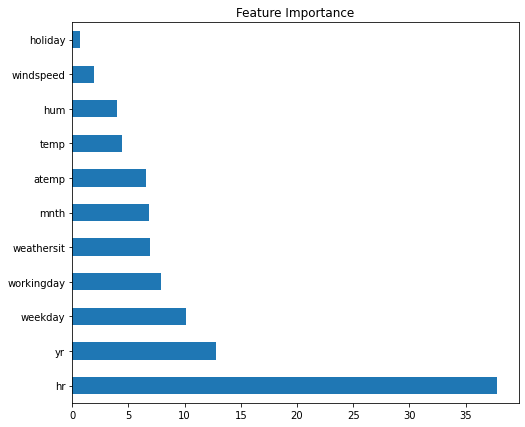

In [ ]:
draw_feature_importance(pd.Series(cat_b.feature_importances_, index=X_train_cat.columns))

Same as for the previous models, hour feqture is here the most important and workingday is on the second place. 

On the third place, we see year feature. It can be explaind by the difference in ditributions depended on the year that we saw on EDA step.

Atemp is much more important than temp despite the fact that they are highly correlated.

# Comparing models

In [ ]:
# mae top
pd.DataFrame(scores, index=['mae', 'time']).T.sort_values(by='mae')

,mae,time
Catboost,27.861376,9.846353
KNN,57.377149,0.212584
linear,62.497996,0.047695
Ridge,62.697023,0.018989
Random_Forest,74.964509,4.169588
Tree,101.086306,22.847175
Lasso,137.831128,0.020191
SVR,607981.120049,39.570550


In [ ]:
# time top
pd.DataFrame(scores, index=['mae', 'time']).T.sort_values(by='time')

,mae,time
Ridge,62.697023,0.018989
Lasso,137.831128,0.020191
linear,62.497996,0.047695
KNN,57.377149,0.212584
Random_Forest,74.964509,4.169588
Catboost,27.861376,9.846353
Tree,101.086306,22.847175
SVR,607981.120049,39.570550


CatBoost showed the best results which are twice higher than knn's mae which is on the second place. However, CatBoost's fitting time is one of the longest.

KNN (probably considered the simplest model) showed better results than many advanced algorithms. It's fitting time is also good, it is not very fair to evaluate this algorithm by training time, since it does not actually train, but remembers data and then spends a lot of time predicting.

Surprisingly, two linear models (Linear and Ridge) showed top results. Their fittings are also ones of the fastest.

Tree models models can only compete with svr. Their performance is one of the worst and the training time is one of the longest.

SVR... no comments...

# Learning on the 1st year

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          17379 non-null  object 
 1   mnth        17379 non-null  object 
 2   hr          17379 non-null  int64  
 3   holiday     17379 non-null  object 
 4   weekday     17379 non-null  object 
 5   workingday  17379 non-null  object 
 6   weathersit  17379 non-null  int64  
 7   temp        17379 non-null  float64
 8   atemp       17379 non-null  float64
 9   hum         17379 non-null  float64
 10  windspeed   17379 non-null  float64
 11  cnt         17379 non-null  int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 2.3+ MB


In [ ]:
X_train_2011 = df[df['yr'] == '2011'].drop(target, axis=1)
y_train_2011 =  y[df['yr'] == '2011']

X_test_2012 = df[df['yr'] == '2012'].drop(target, axis=1)
y_test_2012 =  y[df['yr'] == '2012']

In [ ]:
#rs_ct = cat_b_y.randomized_search(cat_params,
#                                X_train_2011,
#                                y=y_train_2011,
#                                train_size=0.9,
#                                plot=True)

cat_b_y = CatBoostRegressor(**best_cat_params)

start = time.time()
cat_b_y.fit(X_train_2011, y_train_2011)
fin = time.time()

scores['Catboost_yearly'] = [mae(y_test_2012, cat_b_y.predict(X_test_2012)), fin - start]

0:	learn: 89.1649496	total: 25.4ms	remaining: 6.57s
1:	learn: 77.1792977	total: 48ms	remaining: 6.19s
2:	learn: 69.3263524	total: 74.5ms	remaining: 6.38s
3:	learn: 64.3380872	total: 82.4ms	remaining: 5.27s
4:	learn: 56.6819335	total: 106ms	remaining: 5.42s
5:	learn: 52.3854323	total: 131ms	remaining: 5.54s
6:	learn: 49.3436808	total: 157ms	remaining: 5.66s
7:	learn: 45.7383378	total: 169ms	remaining: 5.32s
8:	learn: 42.9562885	total: 196ms	remaining: 5.47s
9:	learn: 41.8184541	total: 227ms	remaining: 5.67s
10:	learn: 40.0009310	total: 250ms	remaining: 5.66s
11:	learn: 38.8374661	total: 278ms	remaining: 5.75s
12:	learn: 37.3179083	total: 303ms	remaining: 5.76s
13:	learn: 36.1845384	total: 325ms	remaining: 5.71s
14:	learn: 36.0616073	total: 329ms	remaining: 5.38s
15:	learn: 35.1014555	total: 361ms	remaining: 5.51s
16:	learn: 34.3364988	total: 389ms	remaining: 5.56s
17:	learn: 33.1972941	total: 409ms	remaining: 5.5s
18:	learn: 32.3842573	total: 434ms	remaining: 5.51s
19:	learn: 32.2862682

In [ ]:
pd.DataFrame(scores, index=['mae', 'time']).T.sort_values(by='mae')

,mae,time
Catboost,27.861376,9.846353
KNN,57.377149,0.212584
linear,62.497996,0.047695
Ridge,62.697023,0.018989
Random_Forest,74.964509,4.169588
Catboost_yearly,93.104101,7.040147
Tree,101.086306,22.847175
Lasso,137.831128,0.020191
SVR,607981.120049,39.570550


The top model has worsened its performance compared to the training with shuffled data.

It can be explained by data leak which took place while shuffling time depended data.

# Multitarget

In [ ]:
y = pd.DataFrame([registered, casual]).T

X_train_mt_2011 = df[df['yr'] == '2011'].drop(target, axis=1)
y_train_mt_2011 =  y[df['yr'] == '2011']

X_test_mt_2012 = df[df['yr'] == '2012'].drop(target, axis=1)
y_test_mt_2012 =  y[df['yr'] == '2012']

#cat_b_mt = CatBoostRegressor(cat_features=[0, 1, 2, 3, 4, 5, 6],
#                          loss_function='MultiRMSE')
#rs_ct = cat_b_mt.randomized_search(cat_params,
#                                X_train_mt_2011,
#                                y=y_train_mt_2011,
#                                train_size=0.9)

best_cat_params_mt = {'cat_features': [0, 1, 2, 3, 4, 5, 6],
                      'depth': 10,
                      'iterations': 260,
                      'l2_leaf_reg': 0.5,
                      'learning_rate': 0.2,
                      'loss_function': 'MultiRMSE'}

cat_b_mt = CatBoostRegressor(**best_cat_params_mt)
start = time.time()
cat_b_mt.fit(X_train_mt_2011, y_train_mt_2011)
fin = time.time()
scores['CatPCA'] = [mae(y_test_mt_2012, cat_b_mt.predict(X_test_mt_2012)), fin - start]

0:	learn: 99.6832725	total: 73.6ms	remaining: 19.1s
1:	learn: 87.4421431	total: 159ms	remaining: 20.5s
2:	learn: 77.2597775	total: 267ms	remaining: 22.8s
3:	learn: 69.7853461	total: 347ms	remaining: 22.2s
4:	learn: 62.9726332	total: 433ms	remaining: 22.1s
5:	learn: 57.4889389	total: 514ms	remaining: 21.8s
6:	learn: 52.7629282	total: 599ms	remaining: 21.7s
7:	learn: 50.1631597	total: 680ms	remaining: 21.4s
8:	learn: 48.3311146	total: 747ms	remaining: 20.8s
9:	learn: 46.2997551	total: 847ms	remaining: 21.2s
10:	learn: 45.0853191	total: 922ms	remaining: 20.9s
11:	learn: 43.8288672	total: 993ms	remaining: 20.5s
12:	learn: 42.6945357	total: 1.09s	remaining: 20.7s
13:	learn: 41.9364757	total: 1.19s	remaining: 20.9s
14:	learn: 40.7055074	total: 1.28s	remaining: 21s
15:	learn: 39.8443202	total: 1.37s	remaining: 20.9s
16:	learn: 39.4412994	total: 1.47s	remaining: 21s
17:	learn: 38.8679826	total: 1.56s	remaining: 20.9s
18:	learn: 38.2584824	total: 1.64s	remaining: 20.9s
19:	learn: 37.3818071	tot

In [ ]:
pred = cat_b_mt.predict(X_test_mt_2012)

In [ ]:
reg_pred, cas_pred = [], []
for r, c in pred:
  reg_pred.append(r)
  cas_pred.append(c)

In [ ]:
print('Registered score:', mae(reg_pred, y_test_mt_2012['registered']))
print('Casual score:', mae(reg_pred, y_test_mt_2012['casual']))

Regidtered score: 76.99553446737752
Casual score: 81.48365629502446


Registered score is less than casual despite the fact that the scale of the values originally is larger.

In [ ]:
cnt_pred_mt = np.array(reg_pred) + np.array(cas_pred)
cnt_test_mt = y_test_mt_2012['registered'] + y_test_mt_2012['casual']

In [ ]:
print('Registered + Casual score:', mae(cnt_pred_mt, cnt_test_mt))

Registered + Casual score: 90.25702281936097


MAE got a bit less compared to the previous section.

# Trying with dimmentional reduction
As multicolinearity was observed, we can reduce its impact on the results using DR

In [ ]:
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# cat_b_pca = CatBoostRegressor(loss_function='MAE')
# rs_ct = cat_b_pca.randomized_search(cat_params,
#                                 X_train_pca,
#                                 y=y_train,
#                                 train_size=0.9)

best_cat_params_pca = {'depth': 10,
                      'iterations': 260,
                      'l2_leaf_reg': 0.5,
                      'learning_rate': 0.2,
                      'loss_function': 'MAE'}
cat_b_pca = CatBoostRegressor(**best_cat_params_pca)
start = time.time()
cat_b_pca.fit(X_train_pca, y_train)
fin = time.time()

scores['CatPCA'] = [mae(y_test, cat_b_pca.predict(X_test_pca)), fin - start]

0:	learn: 136.7664206	total: 125ms	remaining: 32.5s
1:	learn: 135.4767076	total: 238ms	remaining: 30.7s
2:	learn: 134.6532319	total: 356ms	remaining: 30.5s
3:	learn: 133.3907247	total: 466ms	remaining: 29.8s
4:	learn: 132.6603566	total: 578ms	remaining: 29.5s
5:	learn: 131.8090288	total: 694ms	remaining: 29.4s
6:	learn: 130.7014097	total: 819ms	remaining: 29.6s
7:	learn: 130.1067441	total: 939ms	remaining: 29.6s
8:	learn: 129.3835838	total: 1.05s	remaining: 29.3s
9:	learn: 128.9441132	total: 1.17s	remaining: 29.2s
10:	learn: 128.1094900	total: 1.28s	remaining: 29.1s
11:	learn: 127.5584797	total: 1.4s	remaining: 28.9s
12:	learn: 126.8274893	total: 1.52s	remaining: 28.9s
13:	learn: 126.0765749	total: 1.63s	remaining: 28.7s
14:	learn: 125.2174910	total: 1.76s	remaining: 28.7s
15:	learn: 124.5284346	total: 1.87s	remaining: 28.5s
16:	learn: 123.7721581	total: 1.98s	remaining: 28.4s
17:	learn: 123.4302361	total: 2.09s	remaining: 28.2s
18:	learn: 122.8842297	total: 2.21s	remaining: 28.1s
19:	

In [ ]:
pd.DataFrame(scores, index=['mae', 'time']).T.sort_values(by='mae')

,mae,time
Catboost,27.861376,9.846353
KNN,57.377149,0.212584
linear,62.497996,0.047695
Ridge,62.697023,0.018989
Random_Forest,74.964509,4.169588
Catboost_yearly,93.104101,7.040147
Tree,101.086306,22.847175
Lasso,137.831128,0.020191
CatPCA,146.354961,30.196811
SVR,607981.120049,39.570550


Both the results and the fitting time have deteriorated greatly :(

# Conclusion

After all comparisons, I would like to conclude that the CatBoost model is best suited for solving this problem: it shows the best results with a great advantage. At the same time its fitting time is less than some other models that performed worse on the task.

However, if time is really important, I would choose linear model.

Additionally, fitting only on the 1st year showed how important to prevent data leak in Time depended data.